# Requirement 5

In [7]:
import numpy as np

np.set_printoptions(precision=3)

import numpy as np

class PricingEnvConversion:
    def __init__(self, mu, B, T, conversion_fn, n_customers=100):
        """
        mu: N x P matrix of per-unit profit (price - cost)
        I: total cumulative inventory across all rounds
        T: total number of rounds
        conversion_fn: function which for a given price index gives buying probability
        n_customers: number of potential buyers per round
        """
        self.mu = np.array(mu)
        self.B = B  # cumulative inventory
        self.remaining_inventory = B  # starts equal to B
        self.T = T
        self.conversion_fn = conversion_fn
        self.n_customers = n_customers
        self.t = 0
        self.N, self.P = self.mu.shape

    def round(self, price_vector):
        if self.t >= self.T:
            raise Exception("Environment finished all rounds.")

        rewards_per_unit = np.zeros(self.N)
        demand = np.zeros(self.N, dtype=int)
        profit = np.zeros(self.N)

        for i in range(self.N):
            price_idx = price_vector[i]
            if price_idx == -1:
                # skip this product
                continue
            # compute reward and demand
            rewards_per_unit[i] = self.mu[i, price_idx]
            prob = self.conversion_fn(price_idx)
            demand[i] = np.random.binomial(self.n_customers, prob)
            profit[i] = rewards_per_unit[i] * demand[i]

        self.t += 1
        return demand, profit


In [8]:
from scipy import optimize


class CombinatorialUCB:
    def __init__(self, N, P, B, T):
        """
        N: number of products
        P: number of prices
        B: shared capacity (not used right now)
        """
        self.N = N
        self.P = P
        self.B = B
        self.T = T
        self.counts = np.zeros((N, P))  # times each arm is chosen
        self.means = np.zeros((N, P))   # estimated mean rewards
        self.avg_c = np.zeros((N, P))
        self.t = 0

    def pull_arm(self, explore_rounds=10):
        """
        Choose prices for each product.
        Args:
            explore_rounds: number of initial rounds to explore each product systematically
        Returns:
            prices: list of chosen price indices per product (-1 = not sold)
        """
        prices = []
        explore_rounds = self.P

        # If inventory exhausted, sell nothing
        if self.B < 1:
            prices = [-1] * self.N
            return prices

        # Early exploration
        if self.t < explore_rounds:
            for i in range(self.N):
                # Cycle through prices for each product
                price_idx = self.t % self.P
                prices.append(price_idx)
            return prices

        f_ucbs = self.means + np.sqrt(2*np.log(self.t + 1)/(self.counts + 1e-6))
        c_lcbs = self.avg_c - np.sqrt(2*np.log(self.t + 1)/(self.counts + 1e-6))

        # Compute LP to get probabilities
        gamma = self.compute_opt(f_ucbs, c_lcbs)

        for i in range(self.N):
            probs = gamma[i]
            if probs.sum() > 0:
                probs = probs / probs.sum()
                price_idx = np.random.choice(self.P, p=probs)
                prices.append(price_idx)
            else:
                prices.append(-1)  # skip product if LP gives zero probability

        return prices

    
    def compute_opt(self, f_ucbs, c_lcbs):
        """
        f_ucbs: N x P array of UCB estimates of expected rewards
        c_lcbs: N x P array of LCB estimates of expected consumption
        Returns:
            gamma: N x P array of probabilities over all product/price pairs
                (sums to 1 over the whole matrix)
        """

        rho = max(self.B / max(1, self.T - self.t), 0)

        # Objective function
        c = -f_ucbs.flatten()

        # Inequality constraint: expected cost <= rho
        A_ub = [c_lcbs.flatten()]
        b_ub = [rho]

        # Equality constraint: sum of all probabilities = 1
        A_eq = [np.ones(self.N * self.P)]
        b_eq = [1.0]

        # Bounds: x >= 0
        bounds = (0, None)

        # Solve LP
        res = optimize.linprog(
            c,
            A_ub=A_ub,
            b_ub=b_ub,
            A_eq=A_eq,
            b_eq=b_eq,
            bounds=bounds,
        )

        if res.success:
            gamma = res.x.reshape(self.N, self.P)
        else:
            # fallback: all zeros
            gamma = np.zeros((self.N, self.P))

        return gamma


    def update(self, prices, demand, rewards):
        """
        prices: list of chosen price indices per product (-1 if product not sold)
        demand: list of units sold per product
        rewards: observed per-product reward
        """
        self.t += 1

        for i in range(self.N):
            p = prices[i]
            if p == -1:
                continue  # product not sold, skip

            units_sold = demand[i]

            # Update inventory
            self.B -= units_sold
            if self.B < 0:
                self.B = 0  # inventory can't go negative

            # Update estimated mean reward for this product/price pair
            self.counts[i, p] += 1
            n = self.counts[i, p]
            self.means[i, p] += (rewards[i] - self.means[i, p]) / n

            self.avg_c[i, p] += (units_sold - self.avg_c[i, p]) / n



Deterministic clairvoyant always sells product 2, price 2
Expected total clairvoyant reward: 45000.00

Round  1
  Agent prices:  [0, 0, 0]
  Demand:        [30 30 30]
  Rewards:       [30. 60. 30.]
  Remaining B:   5910
  Cumulative regret: -30.00

Round  2
  Agent prices:  [1, 1, 1]
  Demand:        [24 26 26]
  Rewards:       [48. 78. 78.]
  Remaining B:   5834
  Cumulative regret: -144.00

Round  3
  Agent prices:  [2, 2, 2]
  Demand:        [22 15 17]
  Rewards:       [66. 60. 85.]
  Remaining B:   5780
  Cumulative regret: -265.00

Round  4
  Agent prices:  [3, 3, 3]
  Demand:        [13  7 17]
  Rewards:       [ 52.  35. 119.]
  Remaining B:   5743
  Cumulative regret: -381.00

Round  5
  Agent prices:  [4, 4, 4]
  Demand:        [8 4 4]
  Rewards:       [40. 24. 36.]
  Remaining B:   5727
  Cumulative regret: -391.00

Round  6
  Agent prices:  [-1, -1, 3]
  Demand:        [ 0  0 11]
  Rewards:       [ 0.  0. 77.]
  Remaining B:   5716
  Cumulative regret: -378.00

Round  7
  Age

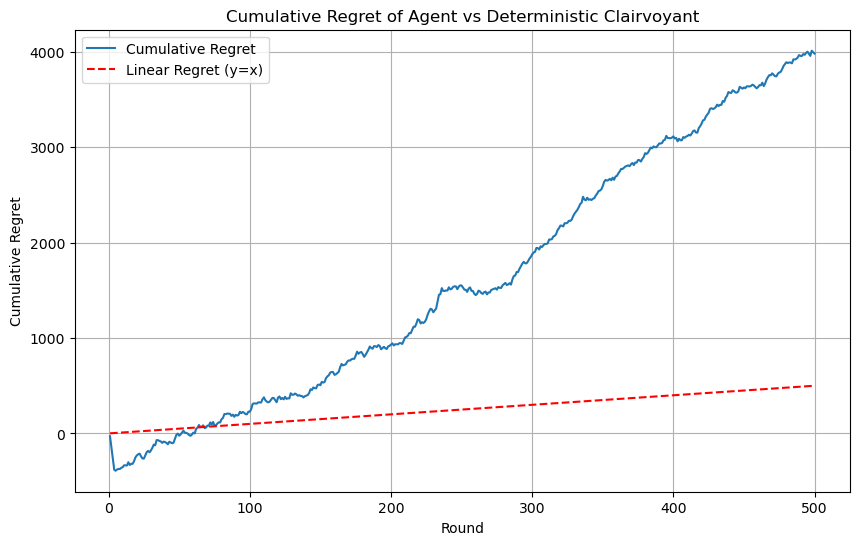

In [9]:
import numpy as np
import matplotlib.pyplot as plt


# Note, the regret is very high because we have the lp, which is not necessary in this stationary environment, but it will be once we add the required non stationarity

np.set_printoptions(precision=3, suppress=True)
np.random.seed(42)

# Environment setup
N, P = 3, 5
B = 6000          # total inventory
T = 500           # number of rounds

# profit matrix
mu = np.array([[1, 2, 3, 4, 5],
               [2, 3, 4, 5, 6],
               [1, 3, 5, 7, 9]])

conversion_fn = lambda price_idx: max(0, 1 - 0.2*price_idx)
n_customers = 30

env = PricingEnvConversion(mu, B=B, T=T, conversion_fn=conversion_fn, n_customers=n_customers)
agent = CombinatorialUCB(N, P, B=B, T=T)

# deterministic clairvoyant (best single product/price pair)
best_reward = 0
best_i, best_j = 0, 0
for i in range(N):
    for j in range(P):
        expected = mu[i,j] * conversion_fn(j) * n_customers
        if expected > best_reward:
            best_reward = expected
            best_i, best_j = i, j

clairvoyant_total_reward = best_reward * T

print(f"Deterministic clairvoyant always sells product {best_i}, price {best_j}")
print(f"Expected total clairvoyant reward: {clairvoyant_total_reward:.2f}\n")

# Run agent
history_agent_rewards = []
cumulative_regret = []

for t in range(T):
    prices_agent = agent.pull_arm()
    demand_agent, rewards_agent = env.round(prices_agent)
    agent.update(prices_agent, demand_agent, rewards_agent)
    
    history_agent_rewards.append(rewards_agent.sum())
    
    # compute cumulative regret
    total_agent_reward = sum(history_agent_rewards)
    regret_t = clairvoyant_total_reward * (t+1)/T - total_agent_reward
    cumulative_regret.append(regret_t)
    
    print(f"Round {t+1:2d}")
    print(f"  Agent prices:  {prices_agent}")
    print(f"  Demand:        {demand_agent}")
    print(f"  Rewards:       {rewards_agent}")
    print(f"  Remaining B:   {agent.B}")
    print(f"  Cumulative regret: {regret_t:.2f}\n")

# Final comparison
total_agent_reward = sum(history_agent_rewards)
total_regret = clairvoyant_total_reward - total_agent_reward

print("=== Final Results ===")
print(f"Total agent reward:       {total_agent_reward:.2f}")
print(f"Deterministic clairvoyant reward: {clairvoyant_total_reward:.2f}")
print(f"Total regret:             {total_regret:.2f}")
plt.figure(figsize=(10,6))
plt.plot(range(1, T+1), cumulative_regret, label='Cumulative Regret')
plt.plot(range(1, T+1), range(1, T+1), 'r--', label='Linear Regret (y=x)')  # linear reference
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret of Agent vs Deterministic Clairvoyant")
plt.grid(True)
plt.legend()
plt.show()

